<a href="https://colab.research.google.com/github/medalidia/apprentissage_git/blob/main/projet_polarite_avis_clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projet NLP ‚Äì Classification de la polarit√© des avis clients
**Auteur : Mohamed Ali Dia**  
**Date : 12 Juillet 2025**  

Ce projet a pour objectif de d√©velopper un syst√®me automatique permettant de classifier un avis client en ligne comme **positif** ou **n√©gatif**, en utilisant un jeu de donn√©es d‚Äôavis en fran√ßais.  
Nous allons passer par les √©tapes suivantes :

- Pr√©traitement des textes (nettoyage, lemmatisation)
- Analyse exploratoire
- Vectorisation des textes (TF-IDF)
- Entra√Ænement de plusieurs mod√®les de classification
- √âvaluation comparative
- Sauvegarde des mod√®les


## 1. Importation des biblioth√®ques

In [6]:

import pandas as pd                   # manipulation de donn√©es en DataFrame
import numpy as np                    # calculs num√©riques
import matplotlib.pyplot as plt       # visualisation graphique
import seaborn as sns                 # visualisation avanc√©e bas√©e sur matplotlib
import re                             # expressions r√©guli√®res pour nettoyage texte
import string                         # manipulation de cha√Ænes (ponctuation)
import nltk                           # traitement de texte (stopwords)
import joblib                         # sauvegarde et chargement de mod√®les
import spacy                          # NLP : lemmatisation, tokenisation avanc√©e
from wordcloud import WordCloud       # g√©n√©ration de nuage de mots
from collections import Counter       # compter la fr√©quence des mots
import itertools                      # op√©rations sur it√©rables
from nltk.corpus import stopwords     # liste des mots vides (stopwords)

from sklearn.model_selection import train_test_split                           # s√©paration train/test
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer   # vectorisation TF-IDF et compte
from sklearn.linear_model import LogisticRegression                            # Logistic Regression
from sklearn.svm import LinearSVC                                              # SVM lin√©aire
from sklearn.ensemble import RandomForestClassifier                            # Random Forest
from sklearn.pipeline import Pipeline                                          # pipeline de traitement
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
    f1_score
)


## 2. Pr√©paration des outils linguistiques

In [7]:

# T√©l√©chargement des stopwords fran√ßais si non d√©j√† pr√©sents
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# Charger la liste des mots vides en fran√ßais
stop_words = set(stopwords.words('french'))

In [9]:
# Chargement du mod√®le SpaCy fran√ßais avec gestion d‚Äôerreur
import subprocess
try:
    nlp = spacy.load("fr_core_news_sm")
except:
    subprocess.run(["python", "-m", "spacy", "download", "fr_core_news_sm"])
    nlp = spacy.load("fr_core_news_sm")

## 3. Chargement du jeu de donn√©es

In [10]:
# D√©finition des chemins vers les splits train, validation, test
splits = {
    'train': 'allocine/train-00000-of-00001.parquet',
    'validation': 'allocine/validation-00000-of-00001.parquet',
    'test': 'allocine/test-00000-of-00001.parquet'
    }

In [11]:
# Chargement du fichier parquet d'entra√Ænement depuis HuggingFace datasets
df = pd.read_parquet("hf://datasets/tblard/allocine/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# # Pour acc√©l√©rer le traitement, on r√©duit √† un √©chantillon de 10 000 exemples pour limiter le temps d'ex√©cution
df = df.sample(10000, random_state=42)

# Ne garder que les colonnes utiles 'review'(texte) et 'label' (polarit√©)
df = df[['review', 'label']]

In [13]:
# Affichage des premi√®res lignes du DataFrame
print(df.head())

                                                   review  label
120476  Un excellent thriller d'action o√π les sc√®nes d...      1
32693   Si le sc√©nariste, qui aurait pu faire un minim...      0
79958   R√©f√©rence dans la filmographie de Bogart, "Le ...      0
76366   Un bon sc√©nario, un bon film, une histoire lou...      1
82343   Un scenario vide et une mise en scene tr√©s sop...      0


## 4. Nettoyage et lemmatisation des textes

In [14]:

"""
    Cette fonction nettoie un texte brut :
    - Passage en minuscules
    - Suppression des chiffres
    - Suppression de la ponctuation
    - Lemmatisation avec SpaCy
    - Suppression des stopwords, des tokens non alphab√©tiques et tr√®s courts (< 3 caract√®res)
  """
def clean_and_lemmatize(text):

    # V√©rifie que l'entr√©e est bien une cha√Æne de caract√®res
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()    # Mise en minuscules
    text = re.sub(r'\d+', '', text)    # Suppression des chiffres
    text = text.translate(str.maketrans('', '', string.punctuation))   # Suppression de la ponctuation

    # Analyse SpaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_.lower() not in stop_words and token.is_alpha and len(token) > 2]
    return " ".join(tokens)   # reconstruire phrase nettoy√©e et lemmatis√©e

In [15]:
# Application de la fonction √† la colonne 'review' pour cr√©er une nouvelle colonne 'clean_review'
df['review'] = df['review'].astype(str)
df['clean_review'] = df['review'].apply(clean_and_lemmatize)

In [16]:
# Afficher un aper√ßu des textes originaux et nettoy√©s
df[['review', 'clean_review']].head()

review  \
120476  Un excellent thriller d'action o√π les sc√®nes d...   
32693   Si le sc√©nariste, qui aurait pu faire un minim...   
79958   R√©f√©rence dans la filmographie de Bogart, "Le ...   
76366   Un bon sc√©nario, un bon film, une histoire lou...   
82343   Un scenario vide et une mise en scene tr√©s sop...   

                                             clean_review  
120476  excellent thriller daction sc√®ne bravoure croi...  
32693   sc√©nariste avoir faire minimum recherche √©vite...  
79958   r√©f√©rence filmographie bogart violent nen rest...  
76366   bon sc√©nario bon film histoire loufoque t√©n√©br...  
82343   scenario vide mise scene trer soporifique fill...

## 5. Exploration des donn√©es

In [17]:
# Afficher la distribution des classes (0 = n√©gatif, 1 = positif)
print(df['label'].value_counts())


label
1    5096
0    4904
Name: count, dtype: int64


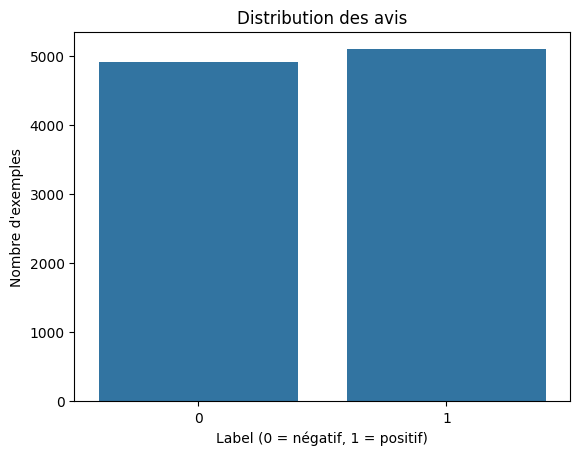

In [18]:
# Visualisation graphique de la r√©partition des classes
sns.countplot(x='label', data=df)
plt.title("Distribution des avis")
plt.xlabel("Label (0 = n√©gatif, 1 = positif)")
plt.ylabel("Nombre d'exemples")
plt.show()

## 6. Visualisation des mots les plus fr√©quents

In [19]:
# Extraction de tous les mots issus de la colonne nettoy√©e
all_words = list(itertools.chain(*df['clean_review'].str.split()))

In [20]:
# Compter la fr√©quence des 20 mots les plus fr√©quents
word_freq = Counter(all_words).most_common(20)
words, counts = zip(*word_freq)

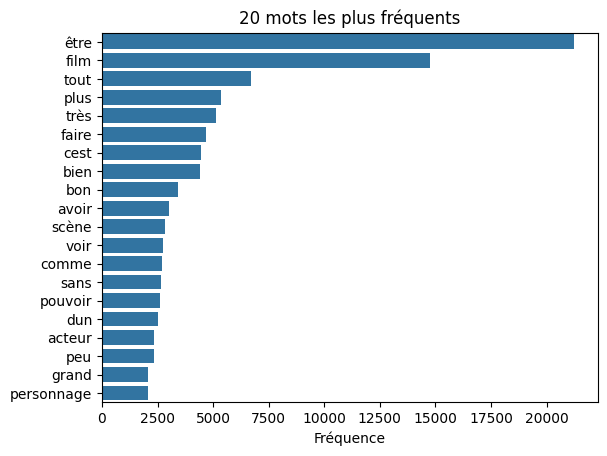

In [21]:
# Affichage sous forme de barplot
sns.barplot(x=counts, y=words)
plt.title("20 mots les plus fr√©quents")
plt.xlabel("Fr√©quence")
plt.show()

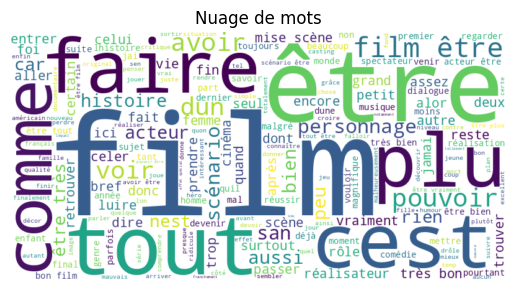

In [22]:
# Nuage de mots bas√© sur l'ensemble des mots
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots")
plt.show()

## 7. Vectorisation des textes avec TF-IDF

In [23]:
# On initialise le vectoriseur TF-IDF en limitant √† 5000 features et en incluant
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

In [24]:
# Calcul de la matrice TF-IDF sur les textes nettoy√©s
X = vectorizer.fit_transform(df['clean_review'])

In [25]:
# R√©cup√©ration des labels
y = df['label']

## 8. S√©paration des donn√©es d'entra√Ænement et de test

In [26]:
# 20% des donn√©es sont r√©serv√©es au test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 9. Entra√Ænement des mod√®les de classification

In [27]:
# R√©gression logistique
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [28]:
# SVM lin√©aire
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [29]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

## 10. √âvaluation des mod√®les

In [30]:
"""
    Cette fonction permet d'afficher la matrice de confusion, le rapport de classification et la pr√©cision globale.
    Elle permet d'affiche aussi graphiquement la matrice de confusion.
    """
def eval_model(name, y_true, y_pred):
    print(f"=== {name} ===")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["N√©gatif", "Positif"])
    plt.title(f"{name} - Matrice de confusion")
    plt.show()

=== R√©gression Logistique ===
[[865 110]
 [104 921]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       975
           1       0.89      0.90      0.90      1025

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Accuracy: 0.893


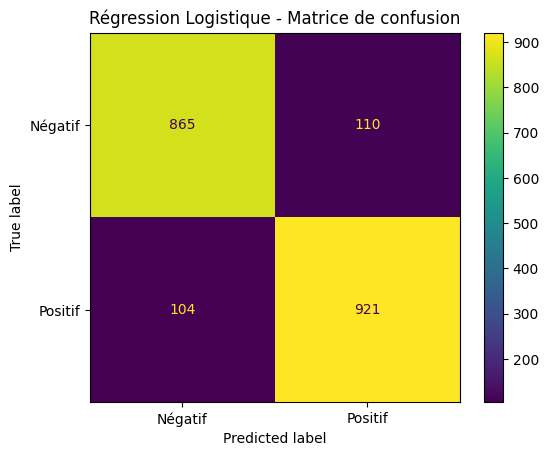

In [31]:
# Evaluation du modele
eval_model("R√©gression Logistique", y_test, y_pred_lr)

=== SVM Lin√©aire ===
[[862 113]
 [110 915]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       975
           1       0.89      0.89      0.89      1025

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Accuracy: 0.8885


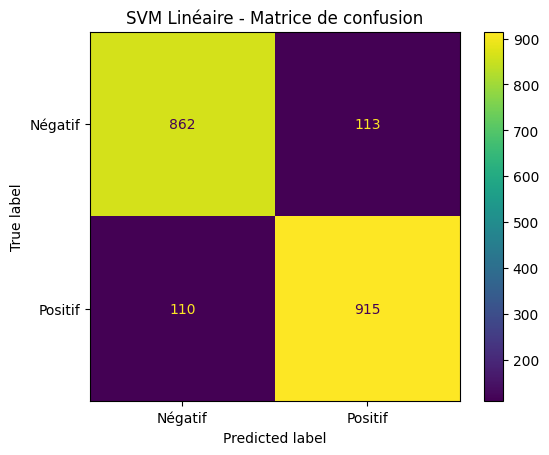

In [32]:
# Evaluation du modele
eval_model("SVM Lin√©aire", y_test, y_pred_svm)

=== Random Forest ===
[[841 134]
 [167 858]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       975
           1       0.86      0.84      0.85      1025

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Accuracy: 0.8495


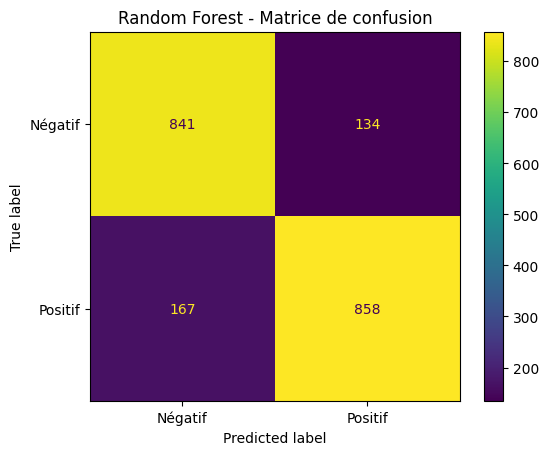

In [33]:
# Evaluation du modele
eval_model("Random Forest", y_test, y_pred_rf)

### üîç F1-score pond√©r√© (compl√©ment d'√©valuation)

Le calcul des F1-score pond√©r√©s est pr√©cieux pour mesurer la performance globale sur les classes d√©s√©quilibr√©es

In [34]:
# Calcul des F1-score pond√©r√©s
print("F1-score pond√©r√© - Logistic Regression :", f1_score(y_test, y_pred_lr, average="weighted"))
print("F1-score pond√©r√© - SVM :", f1_score(y_test, y_pred_svm, average="weighted"))
print("F1-score pond√©r√© - Random Forest :", f1_score(y_test, y_pred_rf, average="weighted"))


F1-score pond√©r√© - Logistic Regression : 0.8929910049478792
F1-score pond√©r√© - SVM : 0.888495564760353
F1-score pond√©r√© - Random Forest : 0.849521109150136


## 11. Comparaison des performances des mod√®les (accuracy)

In [35]:

models = ['Logistic Regression', 'SVM', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_rf)
]

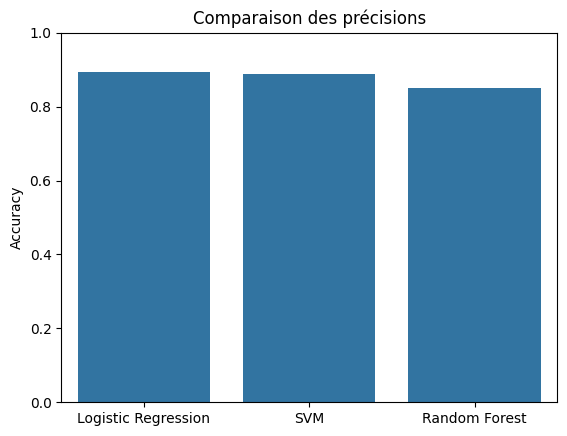

In [36]:
# Graphique de comparaison
sns.barplot(x=models, y=accuracies)
plt.title("Comparaison des pr√©cisions")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

## 12. √âchantillon de pr√©dictions

Exemple de pr√©dictions sur un petit √©chantillon pour voir les r√©sultats concrets

In [37]:
# Test sur un √©chantillon (y_test)
indices = y_test.iloc[:5].index
sample_preds = pd.DataFrame({
    "Review": df.loc[indices, 'review'].values,
    "Label r√©el": y_test.loc[indices].values,
    "Pr√©diction LR": y_pred_lr[:5],
    "Pr√©diction SVM": y_pred_svm[:5],
    "Pr√©diction RF": y_pred_rf[:5]
})
sample_preds


Review  Label r√©el  \
0  l'id√©e de la possession ou du d√©doublement de ...           0   
1  Tr√®s bonne com√©die dramatique, co√©crite et sc√©...           1   
2  M√™me si l'on sent un v√©ritable engagement de P...           0   
3  Son premier film, un court m√©trage, il l'a r√©a...           0   
4  On sait en allant voir ce film qu'on ne pourra...           0   

   Pr√©diction LR  Pr√©diction SVM  Pr√©diction RF  
0              0               0              0  
1              1               1              1  
2              0               0              0  
3              0               0              0  
4              0               0              0

## 13. Sauvegarde des mod√®les entra√Æn√©s pour r√©utilisation future

In [38]:

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")    # vectoriseur TF-IDF
joblib.dump(lr_model, "logistic_model.pkl")        # mod√®le Logistic Regression
joblib.dump(svm_model, "svm_model.pkl")            # mod√®le SVM
joblib.dump(rf_model, "random_forest_model.pkl")   # mod√®le Random Forest

['random_forest_model.pkl']

In [39]:
# Cr√©ation d'un pipeline complet avec vectorisation + mod√®le LR pour simplifier la pr√©diction ult√©rieure
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_lr.fit(df['clean_review'], df['label'])
joblib.dump(pipeline_lr, "pipeline_logistic.pkl")

print("Tous les mod√®les ont √©t√© sauvegard√©s avec succ√®s.")


Tous les mod√®les ont √©t√© sauvegard√©s avec succ√®s.
